In [1]:
h5_file = 'PNKD_CT-depth.h5'

In [2]:
import h5py

hf = h5py.File(h5_file,'r')
y_col = [n.decode('unicode_escape') for n in hf['Tags']]
x_col = range(len(y_col))
max_len = len(hf['Instances'][0])
hf.close()

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 180834912357368706
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6574322484
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16239212465664372937
physical_device_desc: "device: 0, name: GeForce RTX 2080 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"
]


In [4]:
from sklearn.preprocessing import LabelBinarizer

l_encoder = LabelBinarizer()
y_col_one_hot = l_encoder.fit_transform(y_col)

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_col,y_col_one_hot,test_size=0.2,random_state=0)

In [6]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.layers import LSTM, TimeDistributed
from keras.layers import Convolution2D
from keras.layers import Masking

batch_size = 200
epochs = 50
num_classes = 5

Using TensorFlow backend.


In [7]:
model = Sequential()

model.add(TimeDistributed(Convolution2D(32, (7,7), strides=(2, 2),
    #padding='same', activation='relu'), input_shape=self.input_shape))
    padding='same', activation='relu'), input_shape=(None,80,80,1)))
model.add(TimeDistributed(Convolution2D(32, (3,3),
    kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(64, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(128, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(128, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Convolution2D(256, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(Convolution2D(256, (3,3),
    padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.7))
model.add(Masking(mask_value=-10))
#model.add(Masking(mask_value=-0.1))
model.add(LSTM(512, return_sequences=False, dropout=0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 40, 40, 32)  1600      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 38, 38, 32)  9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 19, 19, 32)  0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 19, 19, 64)  18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 19, 19, 64)  36928     
_________________________________________________________

In [8]:
import numpy as np

def h5_image_generator(h5_file,indices,labels,bs,cs,max_len,mode='train'):
    index = 0
    hf = h5py.File(h5_file,'r')
    while True:
        batch_insts = np.full((bs,max_len,80,80,1),-10)
        batch_labels = np.zeros((bs,cs))
        for i in range(bs):
            if len(indices) <= index:
                index = 0
                if mode == 'eval':
                    break
            batch_insts[i] = hf['Instances'][indices[index]]
            batch_labels[i] = labels[index]
            index += 1
        yield(batch_insts,batch_labels)

In [9]:
train_gen = h5_image_generator(h5_file,x_train,y_train,batch_size,
                               num_classes,max_len)
test_gen = h5_image_generator(h5_file,x_test,y_test,batch_size,
                              num_classes,max_len)

In [10]:
H = model.fit_generator(
    train_gen,
    steps_per_epoch = len(x_train) // batch_size,
    validation_data = test_gen,
    validation_steps = len(x_test) // batch_size,
    epochs = epochs)




Epoch 1/50





1286/1286 [==============================] - 1027s 798ms/step - loss: 0.8037 - acc: 0.6664 - val_loss: 0.6232 - val_acc: 0.7575
Epoch 2/50
1286/1286 [==============================] - 1037s 806ms/step - loss: 0.5967 - acc: 0.7660 - val_loss: 0.5601 - val_acc: 0.7762
Epoch 3/50
1286/1286 [==============================] - 1014s 789ms/step - loss: 0.5345 - acc: 0.7899 - val_loss: 0.4968 - val_acc: 0.8045
Epoch 4/50
1286/1286 [==============================] - 1012s 787ms/step - loss: 0.5028 - acc: 0.8026 - val_loss: 0.4705 - val_acc: 0.8152
Epoch 5/50
1286/1286 [==============================] - 1012s 787ms/step - loss: 0.4802 - acc: 0.8114 - val_loss: 0.4592 - val_acc: 0.8193
Epoch 6/50
1286/1286 [==============================] - 1012s 787ms/step - loss: 0.4654 - acc: 0.8183 - val_loss: 0.4527 - val_acc: 0.8222
Epoch 7/50
1286/1286 [==============================] - 1012s 787ms/step - loss: 0.4498 - acc: 0.8242 - val_loss: 0.4633 - val_acc: 0.8156
Epoch 8/50
1286/128

1286/1286 [==============================] - 1011s 786ms/step - loss: 0.3626 - acc: 0.8579 - val_loss: 0.4279 - val_acc: 0.8381
Epoch 48/50
1286/1286 [==============================] - 1010s 785ms/step - loss: 0.3626 - acc: 0.8579 - val_loss: 0.4398 - val_acc: 0.8320
Epoch 49/50
1286/1286 [==============================] - 1117s 869ms/step - loss: 0.3602 - acc: 0.8588 - val_loss: 0.4242 - val_acc: 0.8381
Epoch 50/50
1286/1286 [==============================] - 1093s 850ms/step - loss: 0.3643 - acc: 0.8575 - val_loss: 0.4353 - val_acc: 0.8337


In [11]:
hf.close() #MIGHT NOT DO ANYTHING, APPARENTLY FILE REMAINS OPEN IN PYHTON

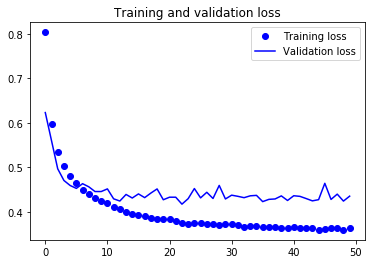

In [12]:
from matplotlib import pyplot as plt

loss = H.history['loss']
val_loss = H.history['val_loss']
plt.figure()
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('H_results_lrcn4_'+str(epochs)+'e.png')
plt.show()

In [13]:
model.save('lrcn4_'+str(epochs)+'e.h5')

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='lrcn4_model_'+str(epochs)+'e.png')

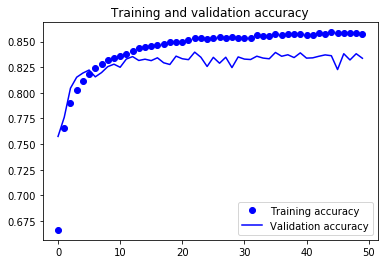

In [15]:
acc = H.history['acc']
val_acc = H.history['val_acc']
plt.figure()
plt.plot(range(epochs), acc, 'bo', label='Training accuracy')
plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('H_accuracy_results_lrcn4_'+str(epochs)+'e.png')
plt.show()